# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# !cp '/content/drive/MyDrive/dermoscopy_classification.tar.gz' .
# !tar -xvzf 'dermoscopy_classification.tar.gz'
data_dir = '/content/drive/MyDrive/dermoscopy_classification'

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from glob import glob
import os
from torch.utils.data import random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F

Mounted at /content/drive


# 2.1-2.2 Μέθοδοι __init__(), **__len__**(), __getitem__()

In [2]:
class MLProject2Dataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, metadata_fname='/content/drive/MyDrive/dermoscopy_classification/metadata.csv', transform=None):

        self.data_dir = data_dir
        self.transform = transform

        # Find all images in the data directory
        image_paths = []
        for part in ["part_1", "part_2"]:
            part_path = os.path.join(data_dir, part)
            image_paths += glob(os.path.join(part_path, "*.jpg"))

        # Create a DataFrame with the image paths
        df = pd.DataFrame({"path": image_paths, "image_id": [os.path.splitext(os.path.basename(p))[0] for p in image_paths]})

        # Load the metadata
        metadata_path = os.path.join(data_dir, metadata_fname)
        metadata = pd.read_csv(metadata_path)

        # Convert DX column to integers
        metadata['dx'] = pd.Categorical(metadata['dx']).codes

        # Combine df and dx label into a pandas DataFrame
        df = pd.merge(df, metadata[['image_id', 'dx']], on='image_id')
        self.df = df


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        img_path = self.df.iloc[idx, 0]  # path is in 1st column
        label = torch.tensor(int(self.df.iloc[idx, 2]))  # dx is in 3rd column
        image = torchvision.io.read_image(img_path).float() / 255.0  # Read image and normalize pixel values to [0-1]

        if self.transform:
            image = self.transform(image)

        return image, label

# 2.3 Train / validation / test split και Data loaders - 2.4 Μετασχηματισμοί

In [31]:
# Define transformations
m, n = 100, 125
data_transforms = transforms.Compose([
    transforms.Resize((m, n)),  # Set m and n to desired dimensions
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean and std deviation for normalization
])

dataset = MLProject2Dataset(data_dir, transform=data_transforms)

# Define the sizes for train, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use the random_split method with a fixed seed
generator = torch.Generator().manual_seed(42)
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=generator)

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
valloader = DataLoader(val_set, batch_size=32)
testloader = DataLoader(test_set, batch_size=32)

# 3.1 train_net

In [23]:
def train_net(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None,
              epochs: int = 10, optimizer: optim = None, loss: nn.modules.loss = None,
              device: str = 'cpu', print_period: int = 10):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    model.to(device)

    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        total = 0

        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            tr_loss = loss(output, target)
            tr_loss.backward()
            optimizer.step()

            train_loss += tr_loss.item()
            _, pred = torch.max(output, 1)
            train_correct += (pred == target).sum().item()
            total += target.size(0)

        train_loss /= len(trainloader.dataset)
        train_acc = 100.0 * train_correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)


        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in valloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                vl_loss = loss(output, target)
                val_loss += vl_loss.item()
                _, pred = torch.max(output, 1)
                val_correct += (pred == target).sum().item()
                val_total += target.size(0)

        val_loss /= len(valloader.dataset)
        val_acc = 100.0 * val_correct / val_total

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

# 3.2 test_net

In [24]:
def test_net(model: nn.Module, testloader: torch.utils.data.DataLoader,
             loss: nn.modules.loss = None, device: str = 'cpu'):

    model.eval()
    pred_labels = []
    true_labels = []
    test_loss = 0.0
    correct = 0
    total = 0

    model.to(device)

    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            ts_loss = loss(output, target)
            test_loss += ts_loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            true_labels.extend(target.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    test_loss /= len(testloader.dataset)
    test_acc = 100.0 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    return pred_labels, true_labels

# 4 Απλό ΣΝ∆

In [25]:
class MyCNN(nn.Module):
    def __init__(self):

        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2688, 7)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [26]:
# Create an instance of the MyCNN model
# Firstly run 2.3-cell with m, n = 50, 62
model = MyCNN()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.1)

Epoch [1/20] - Train Loss: 0.0280, Train Accuracy: 68.16% - Val Loss: 0.0263, Val Accuracy: 69.13%
Epoch [2/20] - Train Loss: 0.0265, Train Accuracy: 70.23% - Val Loss: 0.0263, Val Accuracy: 70.23%
Epoch [3/20] - Train Loss: 0.0256, Train Accuracy: 70.71% - Val Loss: 0.0255, Val Accuracy: 70.23%
Epoch [4/20] - Train Loss: 0.0247, Train Accuracy: 71.68% - Val Loss: 0.0246, Val Accuracy: 70.33%
Epoch [5/20] - Train Loss: 0.0239, Train Accuracy: 72.92% - Val Loss: 0.0284, Val Accuracy: 63.44%
Epoch [6/20] - Train Loss: 0.0236, Train Accuracy: 72.62% - Val Loss: 0.0241, Val Accuracy: 70.73%
Epoch [7/20] - Train Loss: 0.0223, Train Accuracy: 73.74% - Val Loss: 0.0229, Val Accuracy: 74.93%
Epoch [8/20] - Train Loss: 0.0216, Train Accuracy: 74.74% - Val Loss: 0.0231, Val Accuracy: 72.63%
Epoch [9/20] - Train Loss: 0.0207, Train Accuracy: 75.87% - Val Loss: 0.0220, Val Accuracy: 74.13%
Epoch [10/20] - Train Loss: 0.0201, Train Accuracy: 76.10% - Val Loss: 0.0230, Val Accuracy: 74.13%
Epoch [11

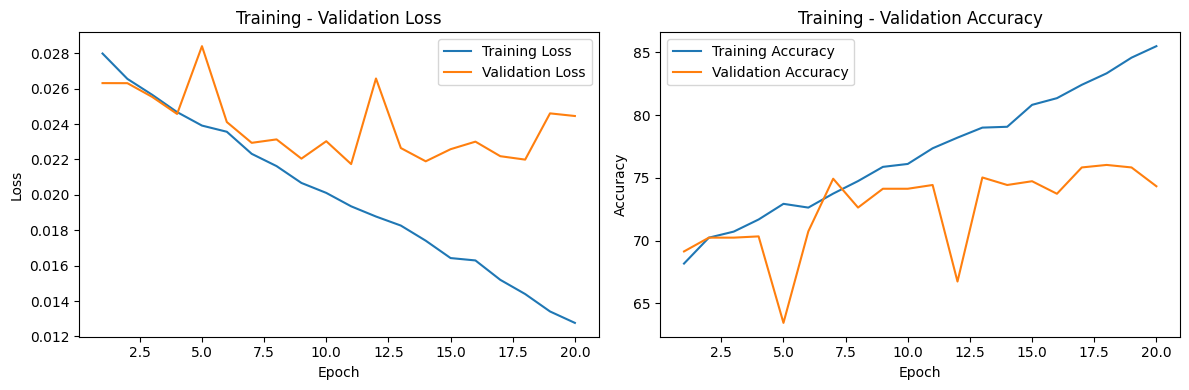

In [28]:
train_losses, train_accuracies, val_losses, val_accuracies = train_net(
    model, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss,
    device='cuda', print_period=1
)

plt.figure(figsize=(12, 4))

epochs = range(1, 21)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training - Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training - Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 0.0234, Test Accuracy: 73.84%


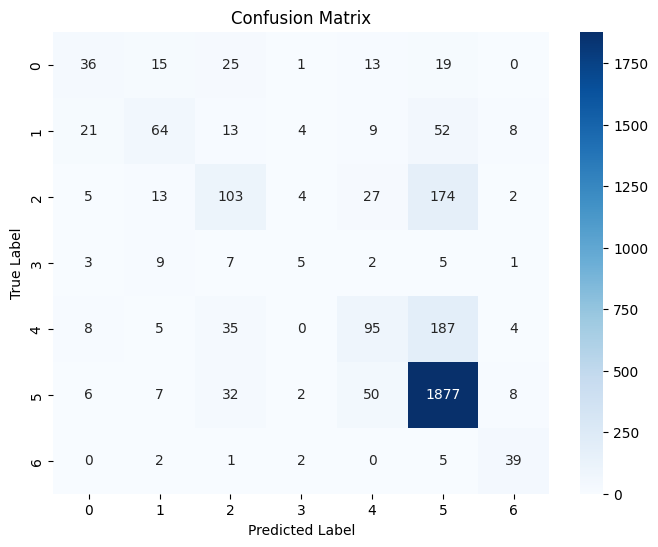

In [29]:
# Evaluate the model in test_set
pred_labels, true_labels = test_net(model, testloader, loss, device="cuda")

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5 Σύνθετο ΣΝ∆

In [32]:
class MyCNN2(nn.Module):
    def __init__(self):

        super(MyCNN2, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, 7)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.avgpool(x)

        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [33]:
# Create an instance of the MyCNN2 model
# Firstly run 2.3-cell with m, n = 100, 125
model = MyCNN2()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/20] - Train Loss: 0.0275, Train Accuracy: 68.33% - Val Loss: 0.0313, Val Accuracy: 64.24%
Epoch [2/20] - Train Loss: 0.0257, Train Accuracy: 70.48% - Val Loss: 0.0234, Val Accuracy: 73.03%
Epoch [3/20] - Train Loss: 0.0234, Train Accuracy: 72.86% - Val Loss: 0.0222, Val Accuracy: 73.43%
Epoch [4/20] - Train Loss: 0.0220, Train Accuracy: 73.71% - Val Loss: 0.0221, Val Accuracy: 73.43%
Epoch [5/20] - Train Loss: 0.0210, Train Accuracy: 75.44% - Val Loss: 0.0210, Val Accuracy: 74.53%
Epoch [6/20] - Train Loss: 0.0199, Train Accuracy: 76.19% - Val Loss: 0.0216, Val Accuracy: 73.93%
Epoch [7/20] - Train Loss: 0.0192, Train Accuracy: 77.03% - Val Loss: 0.0203, Val Accuracy: 75.72%
Epoch [8/20] - Train Loss: 0.0187, Train Accuracy: 77.92% - Val Loss: 0.0206, Val Accuracy: 74.63%
Epoch [9/20] - Train Loss: 0.0176, Train Accuracy: 78.88% - Val Loss: 0.0212, Val Accuracy: 76.02%
Epoch [10/20] - Train Loss: 0.0163, Train Accuracy: 80.40% - Val Loss: 0.0209, Val Accuracy: 75.62%
Epoch [11

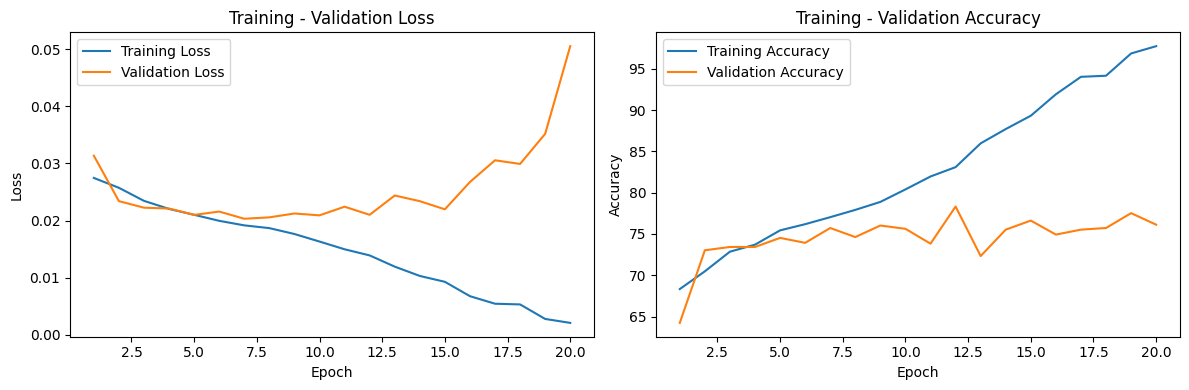

In [34]:
train_losses, train_accuracies, val_losses, val_accuracies = train_net(
    model, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss,
    device='cuda', print_period=1
)

plt.figure(figsize=(12, 4))

epochs = range(1, 21)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training - Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training - Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 0.0480, Test Accuracy: 76.64%


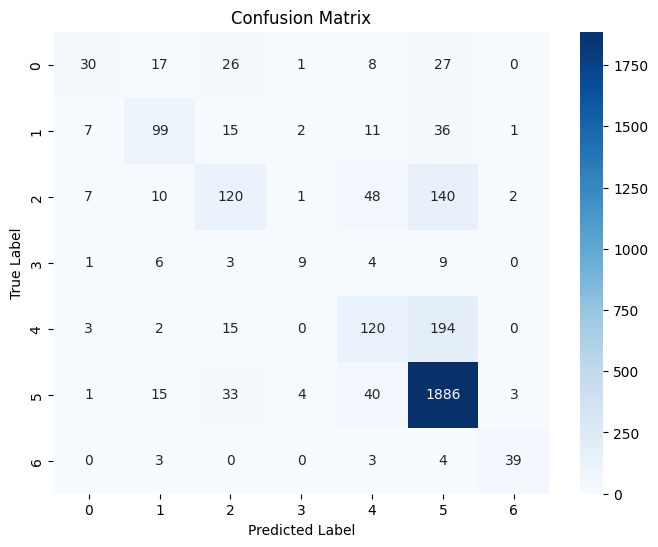

In [35]:
# Evaluate the model in test_set
pred_labels, true_labels = test_net(model, testloader, loss, device="cuda")

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6 Μεταφορά μάθησης - transfer learning

In [36]:
# Creation of the model
model = torchvision.models.resnet34(weights="DEFAULT")

# Tranforms on images
data_transforms = {
    'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset1 = MLProject2Dataset(data_dir, transform=data_transforms['train'])
dataset2 = MLProject2Dataset(data_dir, transform=data_transforms['val'])

train_size = int(0.6 * len(dataset1))
val_size = int(0.1 * len(dataset2))
test_size = len(dataset2) - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_set1, val_set1, test_set1 = random_split(dataset1, [train_size, val_size, test_size], generator=generator)
train_set2, val_set2, test_set2 = random_split(dataset2, [train_size, val_size, test_size], generator=generator)

trainloader1 = DataLoader(train_set1, batch_size=32, shuffle=True)
valloader2 = DataLoader(val_set2, batch_size=32)
testloader2 = DataLoader(test_set2, batch_size=32)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.1MB/s]


In [37]:
criterion1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/5] - Train Loss: 0.0391, Train Accuracy: 68.80% - Val Loss: 0.0197, Val Accuracy: 77.22%
Epoch [2/5] - Train Loss: 0.0244, Train Accuracy: 72.06% - Val Loss: 0.0201, Val Accuracy: 76.32%
Epoch [3/5] - Train Loss: 0.0211, Train Accuracy: 75.24% - Val Loss: 0.0206, Val Accuracy: 75.62%
Epoch [4/5] - Train Loss: 0.0198, Train Accuracy: 76.78% - Val Loss: 0.0178, Val Accuracy: 79.82%
Epoch [5/5] - Train Loss: 0.0189, Train Accuracy: 77.67% - Val Loss: 0.0164, Val Accuracy: 80.72%


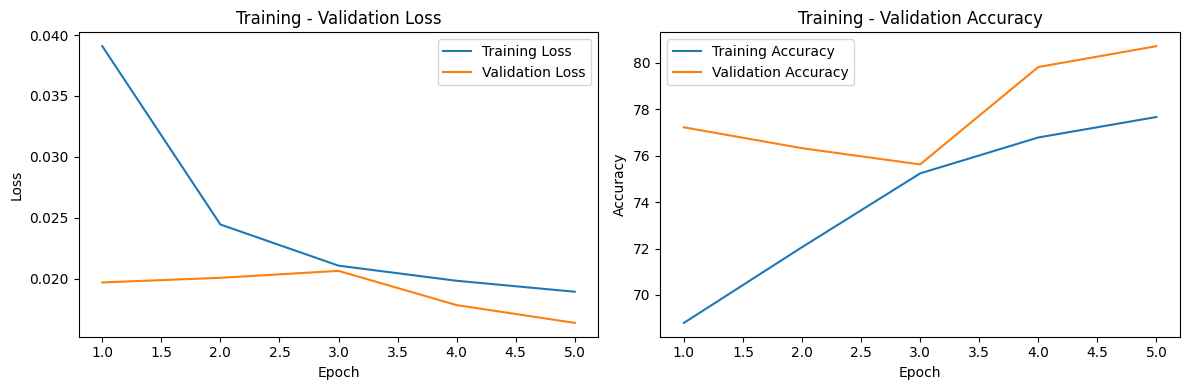

In [38]:
train_losses, train_accuracies, val_losses, val_accuracies = train_net(
    model, trainloader1, valloader2, epochs=5, optimizer=optimizer1, loss=criterion1,
    device='cuda', print_period=1
)

plt.figure(figsize=(12, 4))

epochs = range(1, 6)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training - Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training - Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 0.0157, Test Accuracy: 81.83%


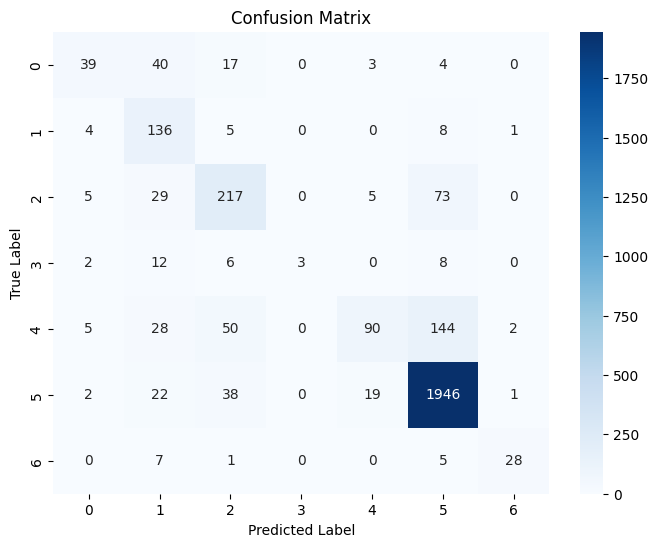

In [39]:
# Evaluate the model in test_set
pred_labels, true_labels = test_net(model, testloader2, criterion1, device="cuda")

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()